In [1]:
import pandas as pd
import numpy as np
from astropy.constants import G
from astropy.constants import M_earth
from astropy.constants import R_earth
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

#pip install astropy

# Introduction
In this analysis, we delve into the intriguing realm of exoplanets, celestial bodies beyond our solar system, to assess their potential habitability for human survival. Leveraging data provided by NASA, we focus on two critical factors: surface gravity and equilibrium temperature. Surface gravity influences the gravitational force experienced by objects on the planet's surface, while equilibrium temperature reflects the balance between the energy absorbed and emitted by the planet. By scrutinizing these key metrics, we aim to discern which exoplanets possess conditions conducive to human habitation, with a primary emphasis on their similarity to Earth in terms of surface gravity and temperature. Through this exploration, we endeavor to contribute insights into the broader quest for identifying potentially habitable worlds beyond our own.

In [2]:
k_data = pd.read_csv("planet.csv")
k_data.columns = ['planet_name', 'num_stars', 'controv_flag', 'orbital_period', 'planet_semi-major_axis', 'planet_radius', 'planet_mass', 'eccentricity', 'insolation_flux', 'equi_temp', 'spectral_type', 'stellar_temp', 'stellar_radius', 'stellar_mass', 'distance']

planet_name = Name of Planet

num_stars = Number of stars

controv_flag = 0 if no controversy, else 1

orbital_period = orbital period [days]

planet_semi-major_axis = distance from star [au]

planet_radius = planet radius [Earth Radius]

planet_mass = planet mass [Earth Mass]

eccentricity = amount by which orbit of planet deviates from a perfect circle (instability in temp)

insolation_flux = Another form of equi_temp [Earth]

equi_temp = planetary equilibrium (The equilibrium temperature of the planet as modeled by a black body heated only by its host star, or for directly imaged planets, the effective temperature of the planet required to match the measured luminosity if the planet were a black body)

spectral_type = Classification based upon Morgan-Keenan system. (Hottest) O, B, A, F, G, K, and M (Coolest). Each letter class is then subdivided using a numeric digit with 0 being hottest and 9 being coolest. Luminosity class 0 or Ia+ is used for hypergiants, class I for supergiants, class II for bright giants, class III for regular giants, class IV for subgiants, class V for main-sequence stars, class sd (or VI) for subdwarfs, and class D (or VII) for white dwarfs.

stellar_radius = radius of star [Sol Radius]

stellar_mass = mass of star [Sol Mass]

distance = distance from Earth [parsec]

In [6]:
#Total rows
k_data['planet_name'].count()

35896

In [7]:
#Total planets
k_data['planet_name'].nunique()

5602

In [8]:
#Take duplicates and average the data
avg_data = k_data.groupby('planet_name').mean(numeric_only=True).reset_index()
avg_data.reset_index(drop=True, inplace=True)
avg_data.tail()

,planet_name,num_stars,controv_flag,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,insolation_flux,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance
5597,ups And b,2.0,0.0,4.616229,0.058895,NaN,219.960419,0.030200,NaN,NaN,6137.820000,1.615,1.2500,13.4054
5598,ups And c,2.0,0.0,240.728533,0.827712,NaN,1275.328758,0.238933,NaN,NaN,6117.093333,1.615,1.2625,13.4054
5599,ups And d,2.0,0.0,1285.346167,2.528382,NaN,1616.242590,0.281117,NaN,NaN,6117.093333,1.615,1.2625,13.4054
5600,ups Leo b,1.0,0.0,385.200000,1.180000,NaN,162.092490,0.320000,NaN,NaN,4836.000000,11.220,1.4800,52.5973
5601,xi Aql b,1.0,0.0,136.860000,0.628333,NaN,716.301647,0.029500,NaN,NaN,4810.500000,11.430,1.7800,56.1858


In [9]:
def first_non_zero(s):
    non_zero_values = s[s != '0']
    if len(non_zero_values) > 0:
        return non_zero_values.iloc[0]
    else:
        return '0'
# Save Spectral_Type data
k_data['spectral_type'] = k_data['spectral_type'].fillna('0').astype(str)
spectral = k_data.groupby('planet_name')['spectral_type'].agg(first_non_zero)
avg_data_reset_index = avg_data.reset_index()
avg_data_with_spectral = pd.merge(avg_data_reset_index, spectral, on='planet_name', how='left')
avg_data_with_spectral

,index,planet_name,num_stars,controv_flag,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,insolation_flux,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance,spectral_type
0,0,11 Com b,2.0,0.0,324.620000,1.226000,NaN,5505.066163,0.234500,NaN,NaN,4808.000000,16.380000,2.463333,93.1846,G8 III
1,1,11 UMi b,1.0,0.0,516.219985,1.526667,NaN,3818.094733,0.080000,NaN,NaN,4276.500000,26.935000,2.093333,125.3210,K4 III
2,2,14 And b,1.0,0.0,186.300000,0.761667,NaN,1224.550433,0.000000,NaN,NaN,4850.500000,11.275000,1.726667,75.4392,K0 III
3,3,14 Her b,1.0,0.0,1766.378417,2.814750,NaN,1642.383591,0.362925,NaN,NaN,5296.985000,0.976667,0.927143,17.9323,K0 V
4,4,16 Cyg B b,3.0,0.0,799.375000,1.662833,NaN,533.514528,0.676033,NaN,NaN,5728.594000,1.140000,1.016000,21.1397,G2.5 V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5597,5597,ups And b,2.0,0.0,4.616229,0.058895,NaN,219.960419,0.030200,NaN,NaN,6137.820000,1.615000,1.250000,13.4054,F8 V
5598,5598,ups And c,2.0,0.0,240.728533,0.827712,NaN,1275.328758,0.238933,NaN,NaN,6117.093333,1.615000,1.262500,13.4054,F8 V
5599,5599,ups And d,2.0,0.0,1285.346167,2.528382,NaN,1616.242590,0.281117,NaN,NaN,6117.093333,1.615000,1.262500,13.4054,F8 V
5600,5600,ups Leo b,1.0,0.0,385.200000,1.180000,NaN,162.092490,0.320000,NaN,NaN,4836.000000,11.220000,1.480000,52.5973,G9 III


In [11]:
avg_data_with_spectral.rename(columns={'spectral_type_y' : 'spectral_type'}, inplace=True)
avg_data = avg_data_with_spectral
# Checking NAN counts for each row.
for column in avg_data.columns:
    nan_count = avg_data[column].isna().sum()
    print(f"Number of NaN values in '{column}': {nan_count}")

Number of NaN values in 'index': 0
Number of NaN values in 'planet_name': 0
Number of NaN values in 'num_stars': 0
Number of NaN values in 'controv_flag': 0
Number of NaN values in 'orbital_period': 249
Number of NaN values in 'planet_semi-major_axis': 296
Number of NaN values in 'planet_radius': 1361
Number of NaN values in 'planet_mass': 2907
Number of NaN values in 'eccentricity': 777
Number of NaN values in 'insolation_flux': 1710
Number of NaN values in 'equi_temp': 1462
Number of NaN values in 'stellar_temp': 392
Number of NaN values in 'stellar_radius': 535
Number of NaN values in 'stellar_mass': 28
Number of NaN values in 'distance': 118
Number of NaN values in 'spectral_type': 0


In [13]:
#Remove rows that have controversy
avg_data_filtered = avg_data.loc[avg_data['controv_flag'] != 1]
avg_data_filtered.reset_index(drop=True, inplace=True)
avg_data_filtered['controv_flag'].nunique()
proj_data = avg_data_filtered
#proj_data.head()
proj_data2 = proj_data.drop(columns=['controv_flag'])
proj_data2.head()

,index,planet_name,num_stars,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,insolation_flux,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance,spectral_type
0,0,11 Com b,2.0,324.620000,1.226000,NaN,5505.066163,0.234500,NaN,NaN,4808.000,16.380000,2.463333,93.1846,G8 III
1,1,11 UMi b,1.0,516.219985,1.526667,NaN,3818.094733,0.080000,NaN,NaN,4276.500,26.935000,2.093333,125.3210,K4 III
2,2,14 And b,1.0,186.300000,0.761667,NaN,1224.550433,0.000000,NaN,NaN,4850.500,11.275000,1.726667,75.4392,K0 III
3,3,14 Her b,1.0,1766.378417,2.814750,NaN,1642.383591,0.362925,NaN,NaN,5296.985,0.976667,0.927143,17.9323,K0 V
4,4,16 Cyg B b,3.0,799.375000,1.662833,NaN,533.514528,0.676033,NaN,NaN,5728.594,1.140000,1.016000,21.1397,G2.5 V


# Factoring in Earth

Mass = 5.9722×10^24 kg

Eccentricity =0.0034 and up to 0.058. AVG = 0.0307

Radius = 3,958.8 miles

Orbital Period = 365

Semi-major Axis of Orbit = 149,598,023 km (or 92,955,902 miles)

Insolation Flux = 1400 W/m

Equilibrium Temp = 255 K

Spectral Type = G-type (G2-V)

Solar Mass = 1.989 × 10^30 kg

Sol Radius = 695,700 kilometres

In [63]:
columns = ['planet_name', 'num_stars', 'orbital_period', 'planet_semi-major_axis', 'planet_radius', 'planet_mass', 'eccentricity', 'insolation_flux', 'equi_temp', 'stellar_temp', 'stellar_radius', 'stellar_mass', 'distance']
earth = pd.DataFrame(columns=columns)
earth_data = {'planet_name' : 'Earth',
              'num_stars' : 1,
              'orbital_period' : 365,
              'planet_semi-major_axis' : 1,
              'planet_radius' : 1,
              'planet_mass' : 1,
              'eccentricity' : 0.0307,
              'insolation_flux' : 0,
              'equi_temp' : 255,
              'stellar_temp' : 5800,
              'stellar_radius' : 1,
              'stellar_mass' : 1,
              'distance' : 0
}
earth = earth.append(earth_data, ignore_index=True)
earth

/tmp/ipykernel_419/224570154.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  earth = earth.append(earth_data, ignore_index=True)


,planet_name,num_stars,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,insolation_flux,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance
0,Earth,1,365,1,1,1,0.0307,0,255,5800,1,1,0


# Steps

1) Calculate planets in habitable zone.

    a) Planetary Equilibrium Temp is easiest. 175 K - 270 K
    
    b) Semi-major axis (distance from spectral body) and spectral type / stellar temp to estimate equi_temp
    


2) Clean data with planets that do not reside in the habitable zone

In [ ]:
# How many planets are habitable based upon our current count?
k_data = proj_data2
habitable = k_data[(k_data['equi_temp'] >= 175) & (k_data['equi_temp'] <= 270)]
count = habitable['planet_name'].count()
missing = k_data['equi_temp'].isna().sum()
print(count, "planets with equilibrium temp within acceptable habitable zone parameters.", missing, "NAN values")

78 planets with equilibrium temp within acceptable habitable zone parameters. 1442 NAN values


In [ ]:
habitable

,index,planet_name,num_stars,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,insolation_flux,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance,spectral_type
171,172,EPIC 248847494 b,1.0,3650.000000,4.500000,12.442000,4131.790000,0.00000,0.190000,183.0,4898.000000,2.7000,0.9000,551.88600,0
179,180,GJ 1002 b,1.0,10.346500,0.045700,NaN,1.080000,NaN,0.670000,231.0,3024.000000,0.1400,0.1200,4.84867,M5.5 V
180,181,GJ 1002 c,1.0,21.202000,0.073800,NaN,1.360000,NaN,0.260000,182.0,3024.000000,0.1400,0.1200,4.84867,M5.5 V
237,239,GJ 357 d,1.0,55.661000,0.204000,NaN,6.100000,NaN,0.380000,220.0,3505.000000,0.3400,0.3400,9.44181,M2.5 V
263,265,GJ 514 b,1.0,140.430000,0.422000,NaN,5.200000,0.45000,0.280000,202.0,3728.000000,0.5000,0.5100,7.61778,M0.5-1.0 V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5292,5318,TRAPPIST-1 g,1.0,12.352981,0.046406,1.134667,1.269667,0.03154,0.253333,198.0,2548.333333,0.1200,0.0875,NaN,0
5304,5330,Teegarden's Star c,1.0,11.412500,0.044900,NaN,1.080000,0.02000,0.360000,209.0,2969.000000,0.1150,0.0950,3.83078,M7.0 V
5433,5461,WASP-41 c,1.0,421.000000,1.070000,NaN,1010.699400,0.29400,NaN,241.0,5545.000000,0.8700,0.9300,163.37100,0
5440,5468,WASP-47 c,1.0,582.500000,1.387667,NaN,422.802300,0.27025,NaN,247.0,5564.000000,1.1475,1.0550,264.78000,0


In [ ]:
# counts after removal of controversies
proj_data2.count()

index                     5572
planet_name               5572
num_stars                 5572
orbital_period            5326
planet_semi-major_axis    5280
planet_radius             4231
planet_mass               2674
eccentricity              4804
insolation_flux           3885
equi_temp                 4130
stellar_temp              5184
stellar_radius            5049
stellar_mass              5549
distance                  5456
spectral_type             5572
dtype: int64

# Solving Missing Equilibrium Temperature

In [22]:
# Does insolation_flux help?
miss_temp = k_data[k_data['equi_temp'].isna()]
#miss_temp.count()
# 93 counts with insolation flux
insol_flux = k_data[~k_data['insolation_flux'].isna()]
insol_flux.head()

,index,planet_name,num_stars,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,insolation_flux,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance,spectral_type
30,30,55 Cnc e,2.0,0.994802,0.019644,1.968556,8.667005,0.081625,2657.83,1894.500000,5239.990833,0.95500,0.922667,12.5855,G8 V
47,47,AU Mic b,1.0,8.463095,0.064860,4.089400,22.221567,0.064539,48.92,649.333333,3675.857143,0.75125,0.515714,9.7221,M1
48,48,AU Mic c,1.0,18.859087,0.110250,2.850667,14.900000,0.043595,7.30,456.500000,3685.750000,0.76200,0.522000,9.7221,0
74,75,BD-210397 b,1.0,1891.000000,2.630000,NaN,214.000000,0.100000,0.02,NaN,4051.000000,0.75000,0.680000,23.7324,K7 V
75,76,BD-210397 c,1.0,6300.000000,5.900000,NaN,1142.288175,0.265000,0.00,NaN,4051.000000,0.75000,0.685000,23.7324,K7 V


In [23]:
insol_habit = insol_flux[(insol_flux['insolation_flux'] >= 175) & (insol_flux['insolation_flux'] <= 300)]
both_habit = insol_habit[(insol_habit['equi_temp'] < 800)]
both_habit

,index,planet_name,num_stars,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,insolation_flux,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance,spectral_type
2343,2362,Kepler-1283 b,1.0,12.946239,0.10696,1.706571,NaN,0.0,210.312,771.0,6089.444444,1.498889,1.04125,2921.99,0


# Conclusion on Insolation Flux

Useless parameter, the planet's who's insolation flux have an equilibrium temperature that is too high to sustain life.

In [26]:
#removing insolation flux from dataframe
#k_data = k_data.drop(columns=['insolation_flux'])
no_flux = k_data
#no_flux.head()

# Continuation of finding NAN equi_temp

Let $T_{s} = $ temperature of star, $R = $ radius of star, $a = $ semi-major axis, and $A_{B} = $ Bond Albedo

$T_{eq} = T_{s}\sqrt{\frac{R}{2a}}(1-A_{B})^{\frac{1}{4}}$

However, we don't have Bond Albedo, and if we did then the scientists that have been focused on this effort would have already done the math...

BUT WE CAN ESTIMATE!!!

Earth's Bond Albedo is 0.29

Bond Albedo is primarily affected by atmosphere. More clouds, more albedo.

Would it be wrong to take an average of all of our planet's bond albedos as our $A_{B}$?

In [27]:
no_flux.head()

,index,planet_name,num_stars,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance,spectral_type
0,0,11 Com b,2.0,324.620000,1.226000,NaN,5505.066163,0.234500,NaN,4808.000,16.380000,2.463333,93.1846,G8 III
1,1,11 UMi b,1.0,516.219985,1.526667,NaN,3818.094733,0.080000,NaN,4276.500,26.935000,2.093333,125.3210,K4 III
2,2,14 And b,1.0,186.300000,0.761667,NaN,1224.550433,0.000000,NaN,4850.500,11.275000,1.726667,75.4392,K0 III
3,3,14 Her b,1.0,1766.378417,2.814750,NaN,1642.383591,0.362925,NaN,5296.985,0.976667,0.927143,17.9323,K0 V
4,4,16 Cyg B b,3.0,799.375000,1.662833,NaN,533.514528,0.676033,NaN,5728.594,1.140000,1.016000,21.1397,G2.5 V


Using 11 Com b as a trial run. $0.3535 = $ average bond albedo sol system planets. Acknowledging this probably only works for G Type stars that are similar to Sol.

Let $T_{s} = 4808$  $R = 11395566$, $a = 183407176$, and $A_{B} = 0.3535$


$T_{eq} = (4808)\sqrt{\frac{11395566}{2 * 183407176}}(1 - 0.3535)^{\frac{1}{4}}$

$T_{eq} = (4808)\sqrt{\frac{11395566}{366814352}}(0.6465)^{\frac{1}{4}}$

$T_{eq} = 847.44(0.89669)$

$T_{eq} = 759.89$

Does this seem right? $1.22$ times further from star. The star is a giant but is colder than Sol. $16$ times larger radius really 

Let's try this same calculation with Earth and see if it's at least similar.

Let $T_{s} = 5800$  $R = 695700$, $a = 149598023$, and $A_{B} = 0.3535$


$T_{eq} = (5800)\sqrt{\frac{695700}{2 * 149598023}}(1 - 0.3535)^{\frac{1}{4}}$

$T_{eq} = 279.68(0.89669)$

$T_{eq} = 250.79$

Actual $= 255$

Error $= |Actual - Estimate| = 4.21$

While that is not how one is supposed to calculate inter-solar equilibrium temperature, that was closer than what I was expecting.

In [28]:
#Function to fill in missing equi_temp
def calc_equi_temp(row):
    if np.isnan(row['equi_temp']): 
        stellar_temp = row['stellar_temp']
        stellar_radius = row['stellar_radius']
        a = row['planet_semi-major_axis']
        stellar_rad = stellar_radius * 695700
        b = a * 149598023
        #print(stellar_temp)
        #print(stellar_rad)
        #print(b)
        return stellar_temp * np.sqrt(stellar_rad / (2 * b)) * 0.89669
    else:
        return row['equi_temp']

In [29]:
trial = no_flux.copy(deep=True)
trial['equi_temp'] = trial.apply(calc_equi_temp, axis=1)
trial.head()

,index,planet_name,num_stars,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance,spectral_type
0,0,11 Com b,2.0,324.620000,1.226000,NaN,5505.066163,0.234500,759.891481,4808.000,16.380000,2.463333,93.1846,G8 III
1,1,11 UMi b,1.0,516.219985,1.526667,NaN,3818.094733,0.080000,776.694550,4276.500,26.935000,2.093333,125.3210,K4 III
2,2,14 And b,1.0,186.300000,0.761667,NaN,1224.550433,0.000000,806.933439,4850.500,11.275000,1.726667,75.4392,K0 III
3,3,14 Her b,1.0,1766.378417,2.814750,NaN,1642.383591,0.362925,134.914123,5296.985,0.976667,0.927143,17.9323,K0 V
4,4,16 Cyg B b,3.0,799.375000,1.662833,NaN,533.514528,0.676033,205.093318,5728.594,1.140000,1.016000,21.1397,G2.5 V


In [30]:
#Remove the two White Dwarves, did the math, wouldn't matter to the data
trial = trial[~trial['spectral_type'].str.contains('WD')]

In [31]:
# Now let's see how many stars we have in the habitable.
habitable2 = trial[(trial['equi_temp'] >= 175) & (trial['equi_temp'] <= 270)]
count2 = habitable2['planet_name'].count()
missing2 = trial['equi_temp'].isna().sum()
print(count2, "planets with equilibrium temp within acceptable habitable zone parameters.", missing2, "NAN values")

212 planets with equilibrium temp within acceptable habitable zone parameters. 660 NAN values


In [32]:
still_missing = trial[trial['equi_temp'].isna()]
still_missing.count()

index                     660
planet_name               660
num_stars                 660
orbital_period            449
planet_semi-major_axis    476
planet_radius             140
planet_mass               524
eccentricity              302
equi_temp                   0
stellar_temp              288
stellar_radius            170
stellar_mass              642
distance                  647
spectral_type             660
dtype: int64

# Problem

If stellar temp, stellar radius, or planet_sma are NAN then unable to find equilibrium, meaning 600 possible planets are still unknown.

For stellar temp, since we know the spectral type in some instances we can further approximate. 

Will use this page for temperature. https://sites.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html

For Stellar Radius we may have to interpolate.

Rows without spectral types will be removed below.

In [33]:
#Removes rows missing spectral type. Lose ~400 rows
still_missing = still_missing[still_missing['spectral_type'] != '0']
still_missing.count()

index                     215
planet_name               215
num_stars                 215
orbital_period            192
planet_semi-major_axis    167
planet_radius              28
planet_mass               188
eccentricity              159
equi_temp                   0
stellar_temp              160
stellar_radius             43
stellar_mass              213
distance                  212
spectral_type             215
dtype: int64

In [34]:
#separating spectral_type into two
split_columns = still_missing['spectral_type'].str.split(expand=True)
still_missing['spectral_type'] = split_columns[0]
still_missing['spectral_subtype'] = split_columns[1] if len(split_columns.columns) > 1 else np.nan
still_missing.count()

index                     215
planet_name               215
num_stars                 215
orbital_period            192
planet_semi-major_axis    167
planet_radius              28
planet_mass               188
eccentricity              159
equi_temp                   0
stellar_temp              160
stellar_radius             43
stellar_mass              213
distance                  212
spectral_type             215
spectral_subtype          146
dtype: int64

In [36]:
# function to fill in missing stellar_temp
def fill_stellar_temp(df):
    III_mapping = {
        #O type Full Info
        'O5': 54000,
        'O6': 45000,
        'O7': 43300,
        'O8': 40600,
        'O9': 37800,
        
        #B type Full Info
        'B0': 29200,
        'B1': 23000,
        'B2': 21000,
        'B3': 17600,
        'B5': 15200,
        'B6': 14300,
        'B7': 13500,
        'B8': 12300,
        'B9': 11400,
        
        #A type Full Info
        'A0': 9600,
        'A1': 9330,
        'A2': 9040,
        'A3': 8750,
        'A4': 8480,
        'A5': 8310,
        'A7': 7920,
        
        #F type Full Info
        'F0': 7350,
        'F2': 7050,
        'F3': 6850,
        'F5': 6700,
        'F6': 6550,
        'F7': 6400,
        'F8': 6300,
        
        #G type Full Info
        'G0': 6050,
        'G1': 5930,
        'G2': 5800,
        'G5': 5660,
        'G8': 5440,
        
        #K type Full Info
        'K0': 5240,
        'K1': 5110,
        'K2': 4960,
        'K3': 4800,
        'K4': 4600,
        'K5': 4400,
        'K7': 4000,
        
        #M type Full Info
        'M0': 3750,
        'M1': 3700,
        'M2': 3600,
        'M3': 3500,
        'M4': 3400,
        'M5': 3200,
        'M6': 3100,
        'M7': 3900,
        'M8': 2700
    }
    
    for index, row in df.iterrows():
        if pd.isna(row['stellar_temp']):
            spectral_type = row['spectral_type']
            if spectral_type in III_mapping:
                df.at[index, 'stellar_temp'] = III_mapping[spectral_type]
    
    return df

filled_trial = fill_stellar_temp(still_missing)
filled_trial.head()

,index,planet_name,num_stars,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance,spectral_type,spectral_subtype
12,12,2MASS J01033563-5515561 AB b,2.0,NaN,84.00,NaN,4131.79000,NaN,NaN,NaN,NaN,0.19,NaN,M5.5/M6,None
15,15,2MASS J04414489+2301513 b,1.0,NaN,15.00,NaN,2383.60000,NaN,NaN,NaN,NaN,0.02,NaN,M8.5,None
18,18,2MASS J22362452+4751425 b,1.0,NaN,230.00,NaN,3972.87500,NaN,NaN,4045.0,NaN,0.60,69.5737,K7,V
45,45,AB Pic b,1.0,NaN,260.00,NaN,4290.50000,NaN,NaN,4960.0,NaN,NaN,50.0475,K2,V
58,58,BD+45 564 b,1.0,307.88,0.83,NaN,432.24663,0.12,NaN,5004.0,NaN,0.81,53.6220,K1,None


In [41]:
#nan_count = filled_trial['stellar_temp'].isna().sum()
#nan_count
#filled_trial[filled_trial['stellar_temp'] == 4960].count()
#trial[trial['stellar_temp'] == 4960].count()
filled_trial = filled_trial.dropna(subset=['stellar_temp'])
filled_trial.count()

index                     187
planet_name               187
num_stars                 187
orbital_period            179
planet_semi-major_axis    139
planet_radius              28
planet_mass               160
eccentricity              147
equi_temp                   0
stellar_temp              187
stellar_radius             42
stellar_mass              185
distance                  187
spectral_type             187
spectral_subtype          132
dtype: int64

In [42]:
# Okay we now have 187 additional stellar temps calculated. 
# Let's fill in missing Semi-Major_axis based upon orbital period
filled_trial.loc[filled_trial['planet_semi-major_axis'].isna(), 'planet_semi-major_axis'] = (filled_trial['orbital_period']**2)**(1/3)
filled_trial.count()
#filled_trial.head(50)

index                     187
planet_name               187
num_stars                 187
orbital_period            179
planet_semi-major_axis    187
planet_radius              28
planet_mass               160
eccentricity              147
equi_temp                   0
stellar_temp              187
stellar_radius             42
stellar_mass              185
distance                  187
spectral_type             187
spectral_subtype          132
dtype: int64

In [43]:
# Now we see we filled in missing planet_sma based upon Kepler's Third Law.
# Once more we can run our calc_equi_temp on 42 exo-planets since we have 42 stellar radius
# However that leaves us with 145 planets still unable to calculate due to missing stellar radius.
filled_trial['equi_temp'] = filled_trial.apply(calc_equi_temp, axis=1)
filled_trial.count()

index                     187
planet_name               187
num_stars                 187
orbital_period            179
planet_semi-major_axis    187
planet_radius              28
planet_mass               160
eccentricity              147
equi_temp                  42
stellar_temp              187
stellar_radius             42
stellar_mass              185
distance                  187
spectral_type             187
spectral_subtype          132
dtype: int64

In [44]:
habitable3 = filled_trial[(filled_trial['equi_temp'] >= 175) & (filled_trial['equi_temp'] <= 270)]
count3 = habitable3['planet_name'].count()
missing3 = filled_trial['equi_temp'].isna().sum()
print(count3, "planets with equilibrium temp within acceptable habitable zone parameters.", missing3, "NAN values")

3 planets with equilibrium temp within acceptable habitable zone parameters. 145 NAN values


In [45]:
# Merge three habitable dataframes

habitable_true = pd.concat([habitable, habitable2, habitable3], ignore_index=True)
habitable_true.count()

index                     293
planet_name               293
num_stars                 293
orbital_period            293
planet_semi-major_axis    289
planet_radius             130
planet_mass               197
eccentricity              270
insolation_flux            70
equi_temp                 293
stellar_temp              293
stellar_radius            291
stellar_mass              293
distance                  275
spectral_type             293
spectral_subtype            0
dtype: int64

In [46]:
# Secondary clean up due to messy data being merged.

# Remove Flux once again
habitable_true.drop(columns=['insolation_flux'])

# Split spectral type
split_columns = habitable_true['spectral_type'].str.split(expand=True)
habitable_true['spectral_type'] = split_columns[0]
habitable_true['spectral_subtype'] = split_columns[1] if len(split_columns.columns) > 1 else np.nan

In [47]:
# Something is wrong. Habit1 = 78, Habit2 = 212, Habit3 = 3
# Found it. Accidentally ran concat more than once. 
# But also found out each habitable had duplicates that needed to be removed.
habitable_true.drop_duplicates(subset='planet_name', inplace=True)

#habitable_true.reset_index(inplace=True)
habitable_true.count()

index                     215
planet_name               215
num_stars                 215
orbital_period            215
planet_semi-major_axis    213
planet_radius              70
planet_mass               165
eccentricity              201
insolation_flux            70
equi_temp                 215
stellar_temp              215
stellar_radius            214
stellar_mass              215
distance                  206
spectral_type             215
spectral_subtype          102
dtype: int64

<AxesSubplot: xlabel='planet_semi-major_axis', ylabel='planet_mass'>

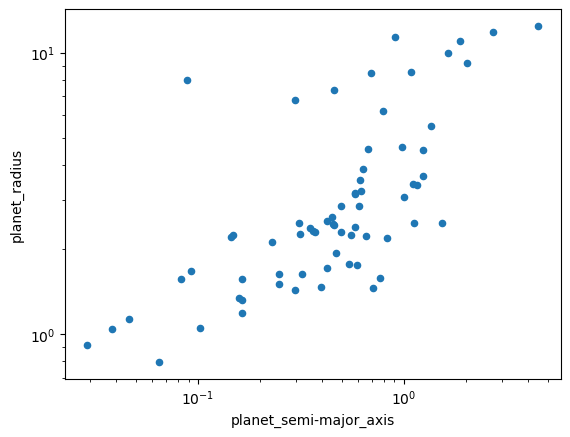

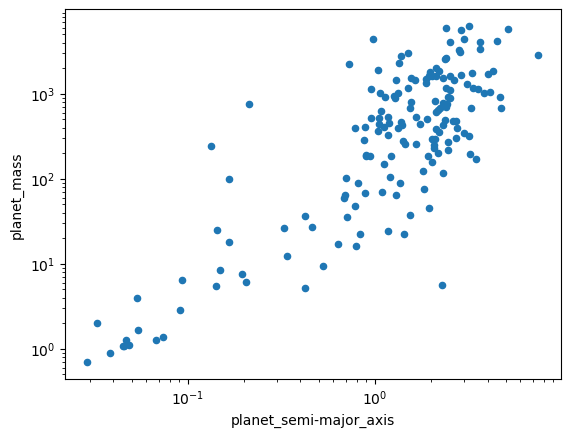

In [49]:
habitable_true["planet_density"] = habitable_true["planet_mass"] / (habitable_true["planet_radius"] ** 3)
habitable_true["planet_surface_gravity"] = G * (habitable_true["planet_mass"] * M_earth )/ ((habitable_true["planet_radius"] * R_earth) ** 2)
habitable_true["planet_dist_to_sellar_radius_ratio"] = habitable_true["planet_semi-major_axis"] / habitable_true["stellar_radius"]

habitable_true.plot(x="planet_semi-major_axis", y="planet_radius", kind="scatter", logx=True, logy=True)

#slope, intercept, r_value, p_value, std_err = linregress(habitable_true["planet_semi-major_axis"], habitable_true["planet_radius"])
#x_values = habitable_true["planet_semi-major_axis"]
#plt.plot(x_values, slope * x_values + intercept, color='red', label='Regression Line')


habitable_true.plot(x="planet_semi-major_axis", y="planet_mass", kind="scatter", logx=True, logy=True)
#habitable_true.plot(x="stellar_radius", y="planet_density", kind="scatter", logx=True, logy=True)
#habitable_true.plot(x="insolation_flux", y="planet_mass", kind="scatter", logx=True, logy=True)
#habitable_true.plot(x="planet_semi-major_axis", y="planet_surface_gravity", kind="scatter", logx=True, logy=True)
#habitable_true.plot(x="planet_dist_to_sellar_radius_ratio", y="planet_surface_gravity", kind="scatter", logx=True, logy=True)
#habitable_true.corr()


# eq_temp 
# density
# mass

# error analysis - how close to earth


In [50]:
nan_rows = habitable_true[habitable_true["planet_radius"].isna()]
non_nan_rows = habitable_true.dropna(subset=["planet_radius"])
nan_rows2 = non_nan_rows[non_nan_rows["planet_semi-major_axis"].isna()]
non_nan_rows = non_nan_rows.dropna(subset=["planet_semi-major_axis"])
non_nan_rows.head()

,index,planet_name,num_stars,orbital_period,planet_semi-major_axis,planet_radius,planet_mass,eccentricity,insolation_flux,equi_temp,stellar_temp,stellar_radius,stellar_mass,distance,spectral_type,spectral_subtype,planet_density,planet_surface_gravity,planet_dist_to_sellar_radius_ratio
0,172,EPIC 248847494 b,1.0,3650.000000,4.500000,12.442000,4131.790000,0.00,0.1900,183.0,4898.000000,2.700000,0.900000,551.8860,0,None,2.145199,261.524830,1.666667
13,1435,K2-18 b,1.0,32.940081,0.147933,2.251222,8.503333,0.21,1.0225,261.2,3466.111111,0.395000,0.407143,38.0266,M2.5,V,0.745305,16.440217,0.374515
14,1593,K2-288 B b,2.0,31.391132,0.164000,1.575000,NaN,NaN,NaN,226.0,3341.000000,0.315000,0.330000,65.6138,M3,V,NaN,NaN,0.520635
16,1851,KIC 9663113 b,1.0,572.383736,1.360650,5.482500,NaN,0.00,1.4725,240.5,6119.601429,1.404286,1.036667,1594.7400,0,None,NaN,NaN,0.968927
17,2052,Kepler-1058 b,1.0,110.964867,0.372520,2.298333,NaN,0.00,0.7700,242.0,4504.596667,0.585000,0.590000,491.9970,0,None,NaN,NaN,0.636786


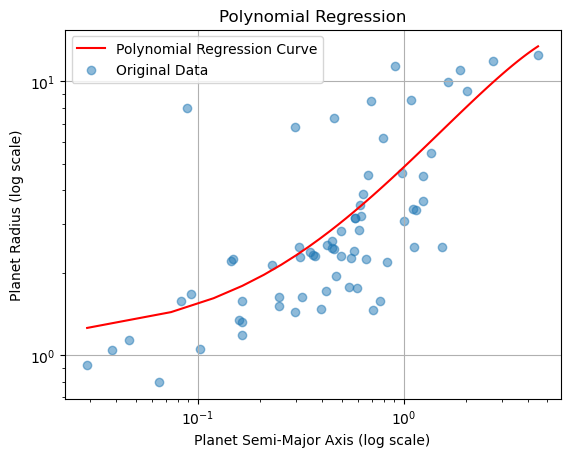

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
#row_index_to_drop = 64
#non_nan_rows = non_nan_rows.drop(row_index_to_drop)

# Create polynomial features
poly_features = PolynomialFeatures(degree=2)  # You can adjust the degree as needed
X_poly = poly_features.fit_transform(non_nan_rows['planet_semi-major_axis'].values.reshape(-1, 1))

# Fit linear regression model
model = LinearRegression()
model.fit(X_poly, non_nan_rows['planet_radius'])

# Generate predictions
x_values = np.linspace(min(non_nan_rows['planet_semi-major_axis']), max(non_nan_rows['planet_semi-major_axis']), 100)
x_values_poly = poly_features.transform(x_values.reshape(-1, 1))
y_values = model.predict(x_values_poly)

# Plot the polynomial regression curve
plt.plot(x_values, y_values, color='red', label='Polynomial Regression Curve')

# Plot the original data points
plt.scatter(non_nan_rows['planet_semi-major_axis'], non_nan_rows['planet_radius'], alpha=0.5, label='Original Data')

# Customize plot
plt.xscale('log')  # Set logarithmic scale for x-axis
plt.yscale('log')  # Set logarithmic scale for y-axis
plt.title('Polynomial Regression')
plt.xlabel('Planet Semi-Major Axis (log scale)')
plt.ylabel('Planet Radius (log scale)')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
missing_data_indices = nan_rows[nan_rows['planet_radius'].isnull()].index

x_values_missing = nan_rows.loc[missing_data_indices, 'planet_semi-major_axis'].values.reshape(-1, 1)
x_values_missing_poly = poly_features.transform(x_values_missing)
y_values_predicted = model.predict(x_values_missing_poly)


nan_rows.loc[missing_data_indices, 'planet_radius'] = y_values_predicted

#nan_rows.head(50)

/tmp/ipykernel_419/2606281114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_rows.loc[missing_data_indices, 'planet_radius'] = y_values_predicted


In [53]:
merged_df = pd.concat([nan_rows, non_nan_rows], ignore_index=True)
merged_df["planet_density"] = merged_df["planet_mass"] / (merged_df["planet_radius"] ** 3)
merged_df["planet_surface_gravity"] = G * (merged_df["planet_mass"] * M_earth )/ ((merged_df["planet_radius"] * R_earth) ** 2)
merged_df["planet_dist_to_sellar_radius_ratio"] = merged_df["planet_semi-major_axis"] / merged_df["stellar_radius"]

merged_df.count()

index                                 213
planet_name                           213
num_stars                             213
orbital_period                        213
planet_semi-major_axis                213
planet_radius                         213
planet_mass                           164
eccentricity                          200
insolation_flux                        69
equi_temp                             213
stellar_temp                          213
stellar_radius                        212
stellar_mass                          213
distance                              204
spectral_type                         213
spectral_subtype                      102
planet_density                        164
planet_surface_gravity                164
planet_dist_to_sellar_radius_ratio    212
dtype: int64

# Planet Radius Filled In

# Planet Mass Interpolation Begins

In [54]:
habitable_true = merged_df.copy()
nan_rows = habitable_true[habitable_true["planet_mass"].isna()]
non_nan_rows = habitable_true.dropna(subset=["planet_mass"])
non_nan_rows.count()


index                                 164
planet_name                           164
num_stars                             164
orbital_period                        164
planet_semi-major_axis                164
planet_radius                         164
planet_mass                           164
eccentricity                          158
insolation_flux                        25
equi_temp                             164
stellar_temp                          164
stellar_radius                        163
stellar_mass                          164
distance                              161
spectral_type                         164
spectral_subtype                       99
planet_density                        164
planet_surface_gravity                164
planet_dist_to_sellar_radius_ratio    163
dtype: int64

Element of x_values: 0.02898575
Element of x_values_scaled [-1.40428302]
Element of y_values: 33.03119884996704


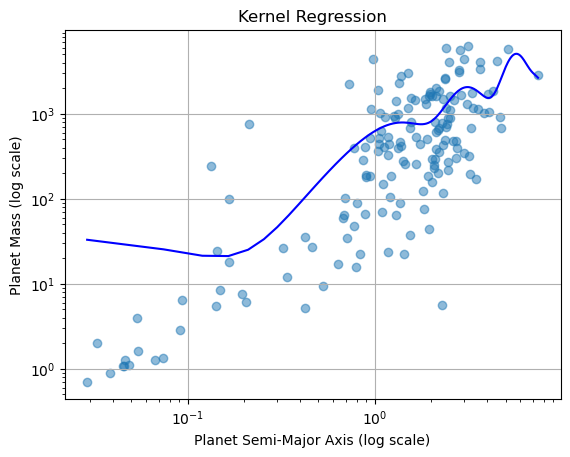

In [55]:
# Create standard scaler
scaler = StandardScaler()

# Scale the features

X_scaled = scaler.fit_transform(non_nan_rows['planet_semi-major_axis'].values.reshape(-1, 1))
#X_scaled_with_origin = np.concatenate((np.zeros((1, 1)), X_scaled), axis=0)
#y_with_origin = np.concatenate((np.array([0]), non_nan_rows['planet_mass'].values), axis=0)

model = KernelRidge(kernel = 'rbf', alpha = 0.1, gamma = 1, coef0 = 0)
model.fit(X_scaled, non_nan_rows['planet_mass'])

x_values = np.linspace(min(non_nan_rows['planet_semi-major_axis']), max(non_nan_rows['planet_semi-major_axis']), 165)
x_values_scaled = scaler.transform(x_values.reshape(-1, 1))
y_values = model.predict(x_values_scaled)
print("Element of x_values:", x_values[0])
print("Element of x_values_scaled", x_values_scaled[0])
print("Element of y_values:", y_values[0])

plt.plot(x_values, y_values, color = 'blue', label = 'Kernel Regression Curve')

# Plot the original data points
plt.scatter(non_nan_rows['planet_semi-major_axis'], non_nan_rows['planet_mass'], alpha = 0.5, label = 'Original Data')

# Customize plot
plt.xscale('log')
plt.yscale('log') 
plt.title('Kernel Regression')
plt.xlabel('Planet Semi-Major Axis (log scale)')
plt.ylabel('Planet Mass (log scale)')
#plt.legend()
plt.grid(True)
plt.show()


# Planet Mass Interpolation Failed

In [58]:
#x_1 = equitemp
#Create pd of only columns we need.
select = ['planet_name',
        'equi_temp',
        'eccentricity',
        'planet_surface_gravity',
         'planet_mass',
         'planet_radius',
         'planet_density']
data = habitable_true[select]
data2 = data.dropna()


In [59]:
#x_2 Gravity https://pubs.aip.org/aapt/pte/article-abstract/57/6/378/278927/Effects-of-Exoplanetary-Gravity-on-Human?redirectedFrom=fulltext
# remove planets with more than 4 g's 
filt_grav = data2[data2['planet_surface_gravity'] < (9.81 * 4)]
filt_grav.count()

planet_name               47
equi_temp                 47
eccentricity              47
planet_surface_gravity    47
planet_mass               47
planet_radius             47
planet_density            47
dtype: int64

In [60]:
#Confidence interval
#yhat = a + bx_1 + cx_2 + dx_3
#range= []
#Mu y|x 
# alpha of 0.05
x_1 = filt_grav['equi_temp']
x_2 = filt_grav['planet_surface_gravity']

x_1.reset_index(drop = True, inplace = True)
x_2.reset_index(drop = True, inplace = True)

B = sm.add_constant(pd.concat([x_1, x_2], axis = 1))

y = np.sqrt((filt_grav['equi_temp'] - 255)**2 + (filt_grav['planet_surface_gravity'] - 9.81)**2)


model1 = sm.OLS(y, B).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1091.
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.25e-38
Time:                        02:55:27   Log-Likelihood:                -126.44
No. Observations:                  47   AIC:                             258.9
Df Residuals:                      44   BIC:                             264.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    220

In [61]:
CI = model1.conf_int()

print("Confidence Intervals: ", CI)

Confidence Intervals:                                   0           1
const                   211.468302  229.439076
equi_temp                -0.878751   -0.802696
planet_surface_gravity    0.138196    0.364131


In [62]:
earth_temp = 255 
earth_gravity = 9.81
Habitability = np.sqrt((filt_grav['equi_temp'] - earth_temp)**2 + (filt_grav['planet_surface_gravity'] - earth_gravity)**2)
Final = filt_grav.copy()
Final['Earth Similarity'] = Habitability
Final = Final[['planet_name', 'Earth Similarity', 'equi_temp', 'planet_surface_gravity', 'planet_mass', 'planet_radius']]
Final = Final.rename(columns={
    'planet_name': 'Planet Name',
    'Earth Similarity': 'Earth Similarity',
    'equi_temp': 'Equilibrium Temperature',
    'planet_surface_gravity': 'Surface Gravity',
    'planet_mass': 'Planet Mass',
    'planet_radius': 'Planet Radius'
})
Final = Final.sort_values(by='Earth Similarity', ascending=False)
Final = Final.reset_index()
Final.head(48)

,index,Planet Name,Earth Similarity,Equilibrium Temperature,Surface Gravity,Planet Mass,Planet Radius
0,14,Teegarden's Star c,79.032492,209.000000,6.078773,1.080000,1.319415
1,20,55 Cnc f,76.192468,251.548888,27.925416,47.391256,4.077808
2,32,HD 10180 g,75.132223,225.614301,5.590494,22.332580,6.256363
3,12,Proxima Cen b,72.382194,225.000000,6.138345,1.113333,1.333105
4,43,HD 11964 b,69.239590,182.838570,15.458893,194.436152,11.101377
5,24,GJ 273 b,58.746824,260.907422,12.551672,2.890000,1.502020
6,22,GJ 1061 d,55.660937,219.786980,8.746109,1.640000,1.355477
7,26,GJ 3293 d,52.785614,215.228739,20.537676,7.600000,1.904183
8,9,HD 86226 b,41.192672,176.000000,30.219996,304.046167,9.928876
9,3,GJ 514 b,22.726247,202.000000,6.617147,5.200000,2.774878


# Conclusion

With $95 \%$ certainty we can say that these planets have a habitability comparison to Earth as rated above. While this does not answer the needed questions of whether the planet has a viable atmosphere or whether liquid water exists on the planet, from a temperature and gravity based requirement for human habitation these planets could support human presence. 

While our analysis provides compelling evidence suggesting that these planets exhibit characteristics akin to Earth's surface gravity and equilibrium temperature, it's crucial to acknowledge the limitations of our methodology.

Firstly, our assessment solely relies on surface gravity and equilibrium temperature as proxies for habitability, overlooking other critical factors such as atmospheric composition, presence of liquid water, and geological stability. The absence of these factors in our analysis underscores the need for comprehensive studies to ascertain the true habitability potential of these exoplanets.

Moreover, while our analysis offers insights into the comparative similarity of these exoplanets to Earth, it's imperative to approach the concept of habitability with caution. Habitability is a multifaceted concept that encompasses a myriad of environmental, geological, and astrophysical considerations. Thus, while our findings suggest potential habitability based on temperature and gravity, further investigation is warranted to validate these assertions.

Nevertheless, our study serves as a foundational step towards identifying promising candidates for future exploration and colonization efforts. By highlighting exoplanets that exhibit Earth-like conditions in terms of temperature and gravity, we provide valuable guidance for prioritizing targets for further observation and research.

In summary, while our analysis provides compelling evidence suggesting habitability comparisons to Earth based on surface gravity and equilibrium temperature, it's essential to recognize the inherent uncertainties and complexities involved in assessing habitability beyond our home planet. Continued research and exploration are essential to unraveling the mysteries of exoplanetary habitability and advancing our understanding of the universe's potential to harbor life.